In [ ]:
import os
import sys
import math
import json
import time
import glob

import cv2
import numpy as np
import pandas as pd
import shutil
import random

from tqdm.notebook import tqdm

from functools import partial, reduce

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from lr_utils import cosine_decay_with_warmup


sys.path.insert(0, os.path.abspath('..'))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'    # Suppress TensorFlow logging

import tensorflow as tf

%load_ext tensorboard

from utils.io import load_image, resize_image
from datasetutils.feature_wrappers import _int64_feature, _string_feature, _bytes_feature

In [2]:
# setting up tensorflow


tf.get_logger().setLevel('ERROR')    # Only TF errors in console    

print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    print(f'Found GPU device: {gpus}')
    tf.config.experimental.set_memory_growth(gpu, True)


2.9.1
Found GPU device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset options

In [3]:
USE_AUGMENTATION = False

# base folders for data and models storage
DATASETS_BASE_PATH = "/media/datasets"
MODELS_BASE_PATH = "/media/models"

In [4]:
GPU_IS_AVAILABLE = tf.test.is_gpu_available()

In [5]:
# TF devices
IO_DEVICE = "CPU:0" 
TRAINING_DEVICE = "GPU:0" if GPU_IS_AVAILABLE else "CPU:0"

In [6]:
# dataset parameters

DTYPE = tf.float32
IMG_WIDTH = 224
IMG_HEIGHT = 224 
IMG_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

DATASET_NAME = "tag_brands"
DATASET_VERSION = 'v2'
DATASET_TASK = 'classification'
DATASET_PATH = f"/media/datasets/{DATASET_NAME}/{DATASET_TASK}/{DATASET_VERSION}/"

#source data, shape vary
SOURCE_DIR_PATH = os.path.join(DATASET_PATH, f'source/')
SOURCE_IMG_PATH = os.path.join(SOURCE_DIR_PATH, f'images/')
SOURCE_LABELS_PATH =  os.path.join(SOURCE_DIR_PATH, f'labels/')

#target data path
TARGET_DIR_PATH = os.path.join(DATASET_PATH, f'target/')
TARGET_IMG_PATH = os.path.join(TARGET_DIR_PATH, 'images/')
TARGET_LABELS_PATH = os.path.join(TARGET_DIR_PATH, 'labels/')

#target tfrecord paths
TFRECORD_IMG_DTYPE = tf.uint8
TFRECORD_DIR_PATH = os.path.join(TARGET_DIR_PATH, f'tfrecord/')
TFRECORD_COMPRESSION_LEVEL = 5

VAL_SIZE = 0.1
TEST_SIZE = 0.2

DATASET_TRAIN_PATH = os.path.join(TFRECORD_DIR_PATH, 'train.tfrecord')
DATASET_VAL_PATH = os.path.join(TFRECORD_DIR_PATH, 'validation.tfrecord')
DATASET_TEST_PATH = os.path.join(TFRECORD_DIR_PATH, 'test.tfrecord')

In [7]:
def build_dataset_structure(ds_path=DATASET_PATH):
    
    # base folder
    ds_path_folders = ds_path.split('/')
    base_folder = os.path.join('/', ds_path_folders[0])
    for folder in ds_path_folders[1:]:
        folder_path = os.path.join(base_folder, folder)
        if os.path.exists(folder_path):
            pass
        else:
            os.mkdir(folder_path)
        base_folder = folder_path
        
    assert(os.path.exists(ds_path))
    
    # source folders
    src_dir_path = os.path.join(ds_path, f'source')
    os.mkdir(src_dir_path)
    src_img_path = os.path.join(src_dir_path, f'images')
    src_lbl_path =  os.path.join(src_dir_path, f'labels')
    
    #target folders
    trgt_dir_path = os.path.join(ds_path, f'target/')
    os.mkdir(trgt_dir_path)
    trgt_img_path = os.path.join(trgt_dir_path, 'images/')
    trgt_lbl_path = os.path.join(trgt_dir_path, 'labels/')
    tf_record_path = os.path.join(trgt_dir_path, f'tfrecord/') #target tfrecord paths
    
    for path in [src_img_path, src_lbl_path, trgt_img_path, trgt_lbl_path, tf_record_path]:
        os.mkdir(path)

In [8]:
def load_model_profile(profile_path):
    with open(profile_path) as file:
        model_profile = json.load(file)
        return model_profile

In [9]:
# build_dataset_structure(DATASET_PATH)

In [10]:
# loading classes description metadata
classes_fpath = os.path.join(SOURCE_LABELS_PATH, "classes.json")
CLASSES = load_model_profile(classes_fpath)
CLASSES = {int(key): value for key, value in CLASSES.items()}
NUM_CLASSES = len(CLASSES)

In [11]:
NUM_CLASSES

337

In [104]:
# CLASSES

In [13]:
# checking class distribution
from glob import glob

flist = glob(f'{SOURCE_IMG_PATH}/*.jpg')
class_statistics = dict()

for fpath in flist:
    class_id = int(fpath.split('.')[-2].split('_')[-1])
    if class_statistics.get(class_id) == None:
        class_statistics[class_id] = 0
    class_statistics[class_id] += 1
    
    
class_statistics = {CLASSES[cls_id]:stat_val for cls_id, stat_val in class_statistics.items()}
class_statistics = dict(sorted(class_statistics.items(), key=lambda item: item[1]))

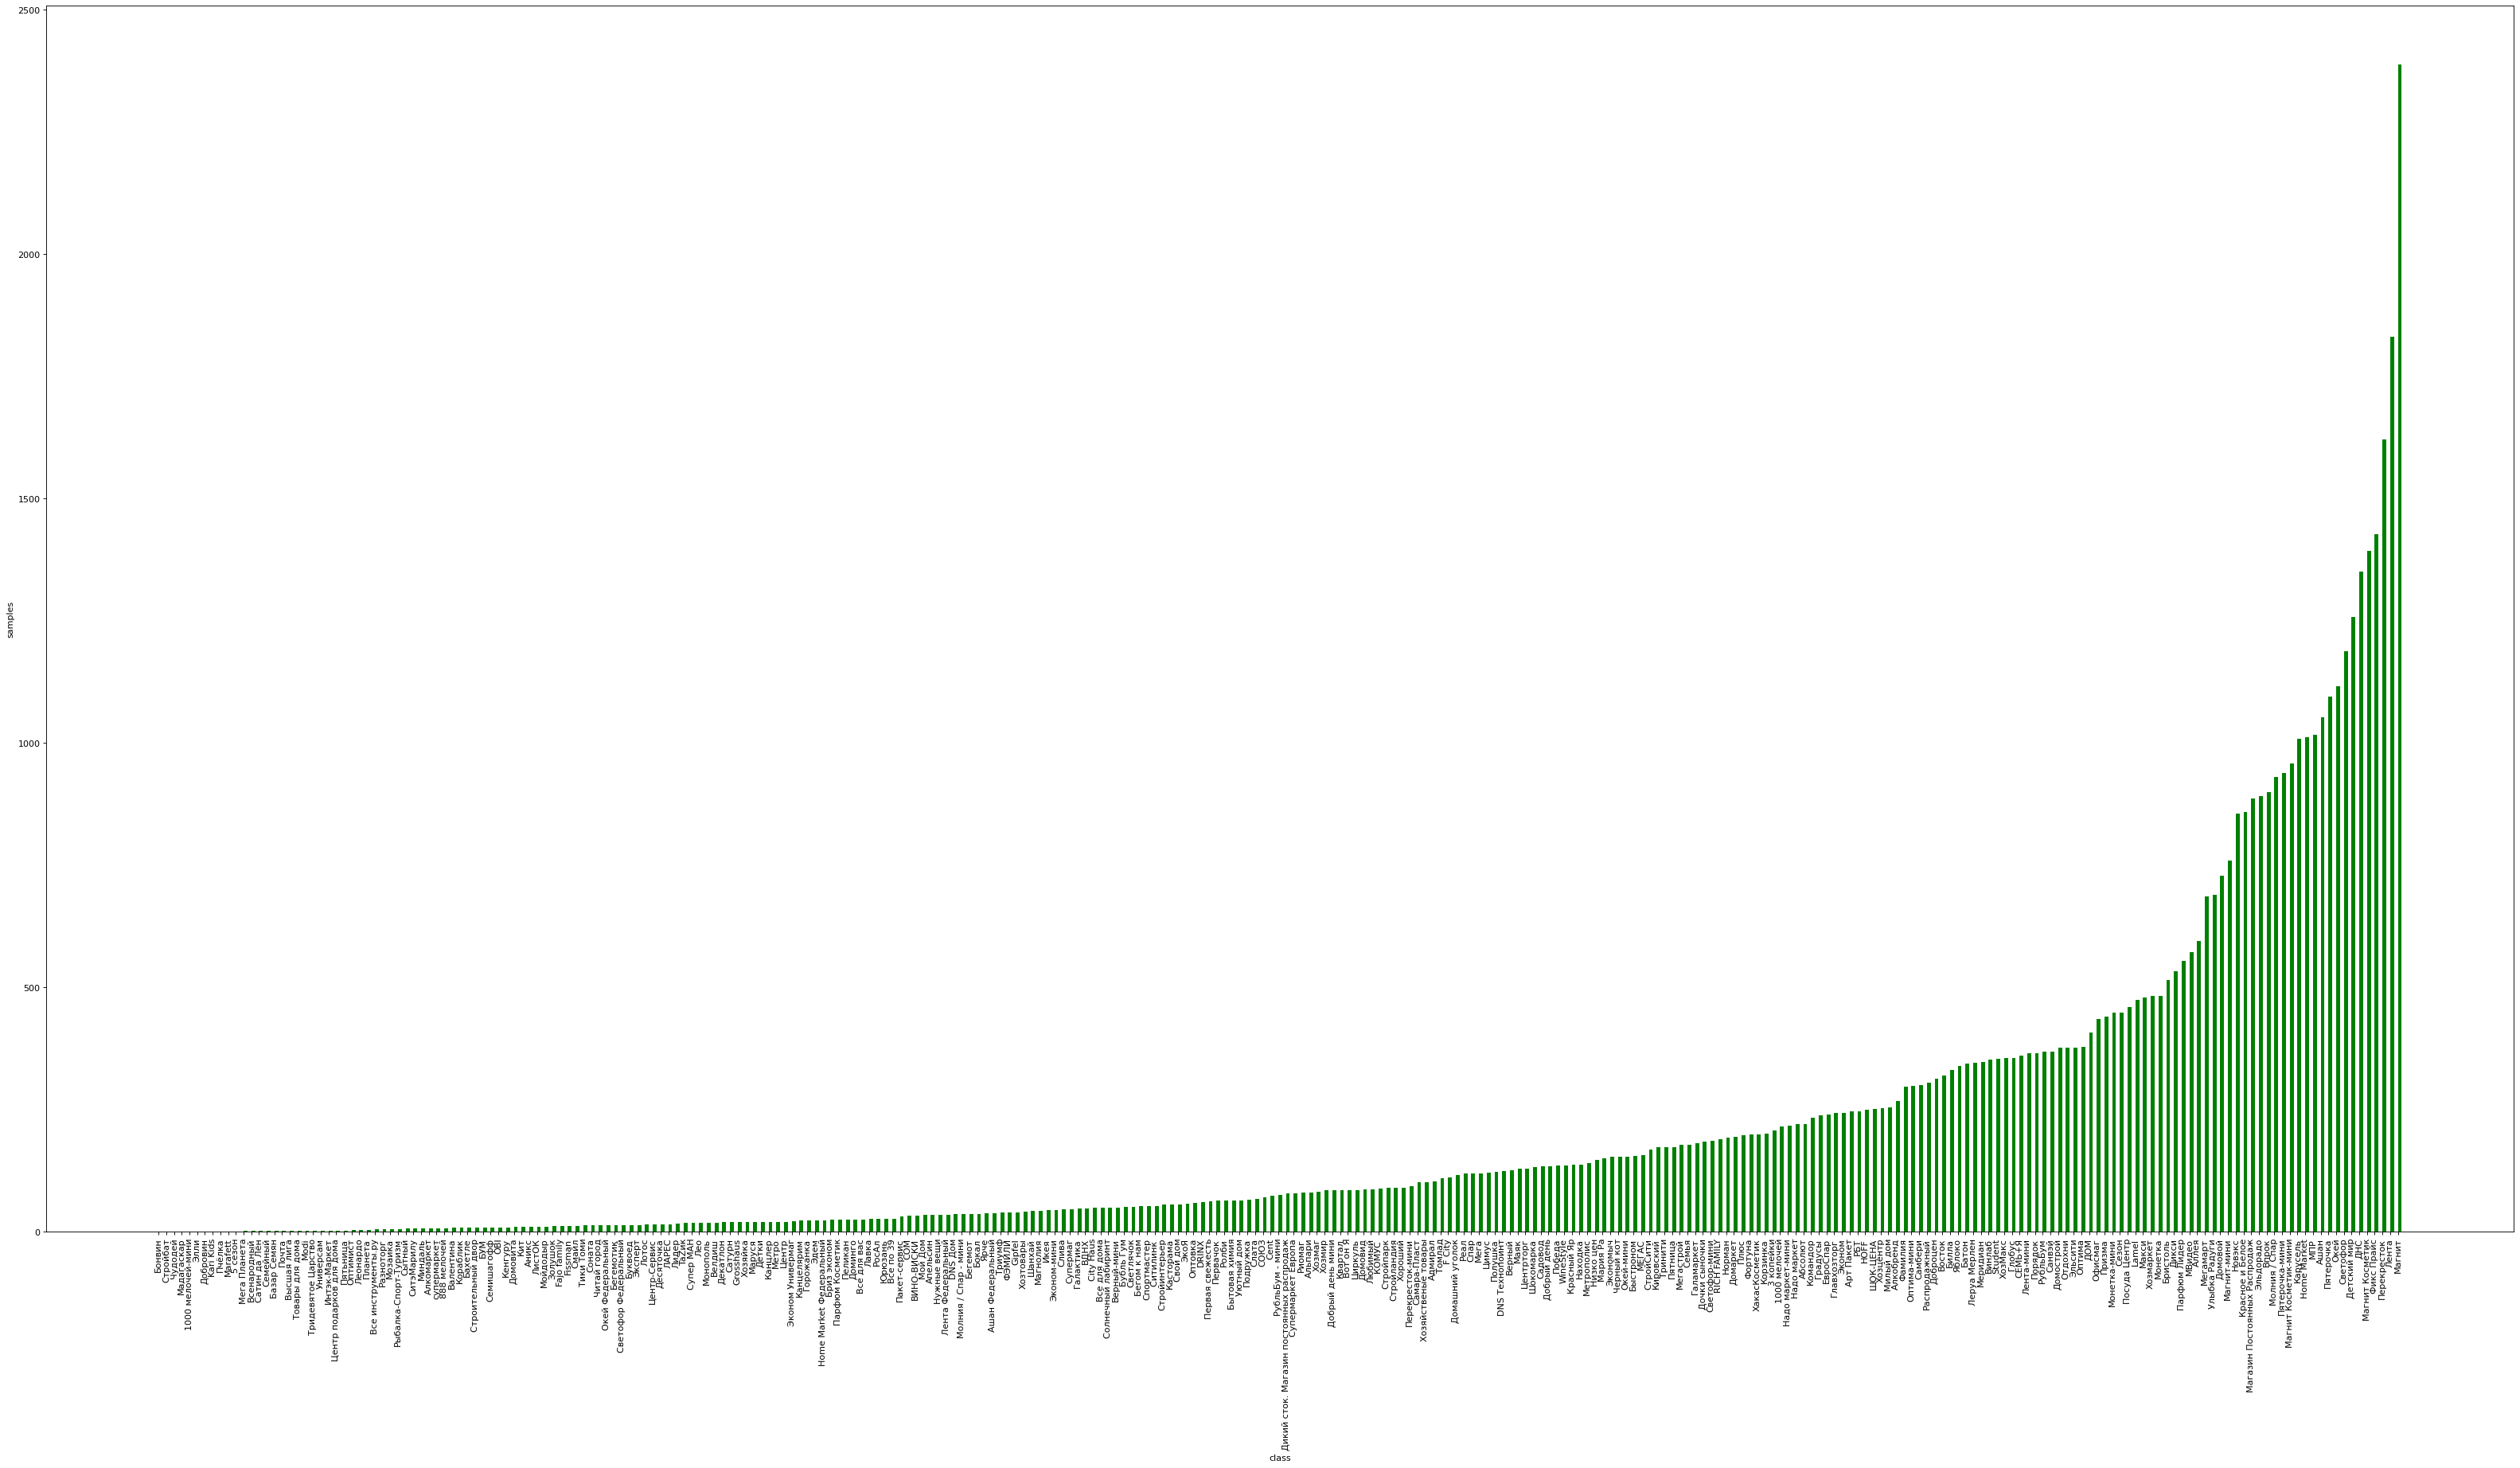

In [14]:
plt.figure(figsize=(50, 25), dpi=80)
ax = plt.gca()

ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=6)

plt.bar(class_statistics.keys(), class_statistics.values(), width=0.5, color='g', align='edge')
plt.xticks(range(len(class_statistics.keys())), class_statistics.keys(), rotation=90)
plt.ylabel("samples")
plt.xlabel("class")
plt.show()

In [103]:
# class_statistics

In [16]:
# limits for downsampling (the dataset is quite unbalanced)
CLASS_SAMPLES_LIMIT = 600

In [17]:
# generate tf example from parsed annotation
def gen_tf_example(fnames, src_path=SOURCE_IMG_PATH, target_size=None):
    '''
    Generates tf.train.Example from source image folder
    src_path : path to source images folder
    target_size: resize if not None
    '''
   
    for fname in tqdm(fnames, unit=' image', desc=f'Generating dataset: '):
        
        tf_example = None
        source_img_path = os.path.join(src_path, fname)
        
        img_fname_split = fname.split('.')[0]
        cls_id = int(img_fname_split.split('_')[-1])        
        
        # reading and resizing image
        with tf.device(IO_DEVICE):
            try:
                with tf.io.gfile.GFile(source_img_path, 'rb') as fid:
                    encoded_img = fid.read()
                    
                img = tf.io.decode_jpeg(encoded_img).numpy()
                img_orig_h, img_orig_w = img.shape[:2]
                
                if target_size is not None:
                    target_h, target_w = target_size
                    img = tf.image.resize(img, (target_h, target_w))
                    height = target_h
                    width = target_w
                else:
                    height = img_orig_h
                    width = img_orig_w
                    
                img = tf.cast(img, TFRECORD_IMG_DTYPE).numpy()
                
                example_img = img.tobytes() 
                
                feature={
                    'height': _int64_feature(height),
                    'width': _int64_feature(width),
                    'filename': _string_feature(fname),
                    'image': _bytes_feature(example_img),
                    'label': _int64_feature(cls_id),
                }
                tf_example = tf.train.Example(features=tf.train.Features(feature=feature))
            
            except Exception as ex:
#                 traceback.print_exc()
                print(ex)
                msg = f'Skipping file: {source_img_path}'
                print(msg)            
        yield tf_example

In [18]:
# dataset build (with primitive undersampling options)

def build_tfrecord_dataset(src_img_path=SOURCE_IMG_PATH,
                        dst_dir_path=TFRECORD_DIR_PATH, 
                        val_split=VAL_SIZE,
                        test_split=TEST_SIZE, 
                        target_shape=INPUT_SHAPE,
                        compression_level=TFRECORD_COMPRESSION_LEVEL,
                        cls_samples_limit=CLASS_SAMPLES_LIMIT):
    '''generates dataset in tf_record format'''
     
    random.seed(21)
    
    target_size = target_shape[:2]
    source_img_fnames = os.listdir(src_img_path)

    print(f"****Building tag classification dataset (.tfrecord).\n Images source path: {src_img_path}.\n Labels source path: {SOURCE_LABELS_PATH}:\n*****")
    
    if not os.path.exists(dst_dir_path):
        os.mkdir(dst_dir_path)
    else:
        shutil.rmtree(dst_dir_path, ignore_errors = True)
        os.mkdir(dst_dir_path)
        
    target_train_path = os.path.join(dst_dir_path, 'train.tfrecord')
    target_val_path = os.path.join(dst_dir_path, 'validation.tfrecord')   
    target_test_path = os.path.join(dst_dir_path, 'test.tfrecord')
        
        
    src_fnames = os.listdir(src_img_path)    
    random.shuffle(src_fnames)
    
    cls_map = dict()
    
    for fname in src_fnames:
        cls_id = int(fname.split('.')[0].split('_')[-1])
        if cls_map.get(cls_id) == None:
            cls_map[cls_id] = list()
            
        # undersamling for large classes
        if len(cls_map[cls_id]) < cls_samples_limit:
            cls_map[cls_id].append(fname)
        
    # trying to take proportional subsets for each class
    train_fnames = [] # training
    test_fnames = []  # test set    
    val_fnames = []   # validation set
        
    for cls in cls_map:
        cls_len = len(cls_map[cls])
        
        if cls_len > 0:
            
            train_size = cls_len - math.ceil(cls_len * (val_split + test_split))
            val_size = int(cls_len * val_split)
            test_size = int(cls_len * test_split)
            
            if train_size == 0:
                train_size = cls_len
                
            train_fnames.extend(cls_map[cls][ :train_size ])
            val_fnames.extend(cls_map[cls][ train_size : train_size + val_size ])
            test_fnames.extend(cls_map[cls][ train_size + val_size: ])
            
            print(f"\nclass: {CLASSES[cls]}\n  train size:{train_size}\n  val size:{val_size}\n  test size: {test_size}")
        else:
            print(f'\nclass {CLASSES[cls]} has no samples. Removing...')
            
       
    if TFRECORD_COMPRESSION_LEVEL != 0:
        options = tf.io.TFRecordOptions(compression_type='GZIP', compression_level=compression_level)
    else:
        options = None
    
    # train data
    with tf.io.TFRecordWriter(target_train_path, options=options) as ds_writer:
        print(f'Writing {target_train_path}:')
        for example in gen_tf_example(train_fnames, target_size=target_size):  
            if example is not None:
                ds_writer.write(example.SerializeToString())
                
    # validation data
    with tf.io.TFRecordWriter(target_val_path, options=options) as ds_writer:
        print(f'Writing {target_val_path}:')
        for example in gen_tf_example(val_fnames, target_size=target_size):  
            if example is not None:
                ds_writer.write(example.SerializeToString())
                    
    # test data
    with tf.io.TFRecordWriter(target_test_path, options=options) as ds_writer:
        print(f'Writing {target_test_path}:')
        for example in gen_tf_example(test_fnames, target_size=target_size):                          
            if example is not None:
                ds_writer.write(example.SerializeToString())
                
    return cls_map


In [19]:
# tf record item extraction fn
def _parse_tf_record(example):
    ''' dataset record parser '''
    features = {    
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'filename': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)    
    }
    sample = tf.io.parse_single_example(example, features)
    
    filename = sample['filename']    
    img_shape = tf.stack([sample['height'], sample['width'], 3])    
    image = tf.io.decode_raw(sample['image'], TFRECORD_IMG_DTYPE)
    image = tf.reshape(image, img_shape)
    
    """
    
    if image.dtype != DTYPE:
        image = tf.cast(image, DTYPE) # target data type...
   
    
    # normalizing
    if image.dtype == tf.float32:
        image = tf.math.divide(image, 127.5)
    elif image.dtype == tf.uint8:
        image = tf.math.divide(image, 255)
    else:
        err_msg = f'Unsupported image data type: {image.dtype}'
        raise Exception(err_msg)
        
    image = tf.math.subtract(image, 1)
    
    """
    
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = int(sample['label'])
    label = tf.one_hot(label, NUM_CLASSES)
    
    return image, label  

In [20]:
# dataset build
def build_dataset():
    ''' builds complete dataset '''
#     build_dataset_structure()                         
    # build dataset
    num_classes_with_data = build_tfrecord_dataset(test_split=TEST_SIZE, compression_level=0)
    print(f'Dataset build complite. Classes with data {num_classes_with_data}, total classes: {NUM_CLASSES}')


# dataset load fn
def load_tfrecord_dataset(
                            path, 
                            batch_size,
                            repeat=False,
                            shuffle_size=1024,
                            compression_level=TFRECORD_COMPRESSION_LEVEL,                              
                            use_augmentation=False
                         ):
    print(f'loading dataset: {path}...', end=' ')
    options = tf.data.experimental.AUTOTUNE
    
    if compression_level != 0:
        dataset = tf.data.TFRecordDataset(path, compression_type="GZIP")
    else:
        dataset = tf.data.TFRecordDataset(path)
    
    dataset = dataset.map(_parse_tf_record, num_parallel_calls=options)
    
    # Shuffle data and create batches
    dataset = dataset.shuffle(shuffle_size)
    
    # apply augmentation 
    if use_augmentation:
        dataset = dataset.map(partial(tf_augment),num_parallel_calls=options)
    
    if repeat:
        dataset = dataset.repeat()
    if batch_size != 0:
        dataset = dataset.batch(batch_size)
        
    # Make dataset fetch batches in the background during the training of the model.
    dataset = dataset.prefetch(options)
    dataset = dataset.cache() 
    print(f'Done!')
    return dataset
    

In [21]:
# augmentation
from albumentations import *

train_crop_height = IMG_HEIGHT // 2
train_crop_width = IMG_WIDTH // 2
transforms = Compose([
            OneOf([
                    Sharpen(p=0.2),
                    Emboss(p=0.2),
                    GaussNoise(p=0.2),
                    Blur(blur_limit=3, p=0.1),
            ], p=0.5),
                        
            OneOf([                
                ToGray(p=0.3),
                RandomGamma(gamma_limit=(80, 120), p=0.5),
                HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       val_shift_limit=10, p=.9),
                RandomBrightnessContrast(p=0.5),
                RGBShift (p=0.5),
            ], p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        ], p=1)


# @tf.function
def aug(image):    
    image = tf.cast(image, tf.uint8).numpy()
    aug_img = transforms(image=image)['image']
    aug_img = tf.cast(aug_img, DTYPE)
    return aug_img

# @tf.function
def tf_augment(image, label):
    im_shape = image.shape
    aug_img = tf.numpy_function(func=aug, inp=[image], Tout = DTYPE)
    aug_img.set_shape(im_shape)
    return aug_img, label

@tf.function
def tf_augment_batch(images, labels):
    aug_imgs = [tf.numpy_function(func=aug, inp=[image], Tout = DTYPE) for image in images]
    return aug_imgs, labels

In [ ]:
existing_data_class_map = build_tfrecord_dataset()
print(f'classes in labelles: {NUM_CLASSES}, classes in dataset: {len(existing_data_class_map)}')

## Model options

In [22]:
source_images_count = reduce(lambda x,y: x+y, [len(x) for x in existing_data_class_map.values()])
AUG = "On" if USE_AUGMENTATION else "Off"

In [23]:
# model parameters
MODEL_VERSION = 3
MODEL_NAME = f'mobile_tag_brand_classifier'
MODEL_AUTHOR = "Eugene Menshoff"
MODEL_LICENSE = ""
MODEL_BASE_PATH = f"{MODELS_BASE_PATH}/{MODEL_NAME}"
MODEL_PATH = os.path.join(MODEL_BASE_PATH, f"{MODEL_VERSION}")
MODEL_PROFILE_PATH = os.path.join(MODEL_PATH, "profile.json")
MODEL_TRAINING_DIR = f'{MODEL_PATH}/training/'
MODEL_CHECKPOINT_PATH = os.path.join(MODEL_TRAINING_DIR, "checkpoints")
MODEL_FROZEN_CHECKPOINT_PATH = os.path.join(MODEL_TRAINING_DIR, "frozen_checkpoints")


TENSORBOARD_LOG_DIR = os.path.join(MODEL_TRAINING_DIR, "tf_log")
SAVED_MODEL_PATH = f'{MODEL_PATH}/saved_model/'
MODEL_DESCRIPTION = \
f"""
Keras mobilenet_v2 -based tag classifier with {len(CLASSES)} classes. 
Trained on {DATASET_NAME}_{DATASET_VERSION} dataset, {source_images_count} images
"""

POOLING = 'max'

# loading model profile from template
MODEL_PROFILE = load_model_profile("pipeline/model_profile_template.json")

In [24]:
# updating model profile
MODEL_PROFILE["name"] = MODEL_NAME
MODEL_PROFILE["version"] = MODEL_VERSION
MODEL_PROFILE["date"] = time.asctime(time.localtime())
MODEL_PROFILE["task"] = "classification"
MODEL_PROFILE["backend"] = f"{tf.__name__}-{tf.__version__}"
MODEL_PROFILE["arcitecture"] = "custom"
MODEL_PROFILE["deploy_target"] = "mobile+server"
MODEL_PROFILE["description"] = MODEL_DESCRIPTION
MODEL_PROFILE["path"] = MODEL_PATH
MODEL_PROFILE["metadata"]["classes"] = CLASSES

In [25]:
# training parаmeters
'''

'''

TRAIN_EPOCHS = 300
TRAIN_BATCH_SIZE = 32
TRAIN_USE_AUG = USE_AUGMENTATION

VAL_BATCH_SIZE = TRAIN_BATCH_SIZE
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE

EVAL_BATCH_SIZE = 1
EVAL_EPOCHS = 1


# model img input parameters
TRAIN_DTYPE = DTYPE
TRAIN_IMG_HEIGHT = IMG_HEIGHT
TRAIN_IMG_WIDTH = IMG_WIDTH
TRAIN_IMG_CHANNELS = IMG_CHANNELS
TRAIN_IMG_SHAPE = (TRAIN_IMG_HEIGHT, TRAIN_IMG_WIDTH, TRAIN_IMG_CHANNELS)
TRAIN_IMG_SIZE = TRAIN_IMG_SHAPE[:2]


TRAIN_USE_FINE_TUNING = False
TRAIN_NUM_WORKERS = 1 # num GPU (for distributed training)
TRAIN_CHKPOINT_SAVE_EVERY_N = 10  # save checkpint every n steps
TRAIN_USE_TPU = False
TRAIN_RECORD_SUMMARIES = False
TRAIN_MODEL_PATH = f"{MODEL_PATH}/train"
TENSORBOARD_LOG_DIR = f"{MODEL_PATH}/train"
TRAIN_MODEL_SAVE_PATH = f"{TRAIN_MODEL_PATH}/saved_model"


WARM_UP_EPOCHS = 2
WARM_UP_LR = 1e-3
BASE_LR = 1e-3
MIN_LR = 1e-10
LOSS = 'categorical_crossentropy'


METRICS = ['accuracy'] 
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=BASE_LR, amsgrad=True)


# pre-trained wights
USE_PREPROCESSING = True
USE_PRE_TRAINED = False
PRE_TRAINED_MODEL_DIR = ''
ENCODER_WEIGTHS = ''
PRE_TRAINED_MODEL_DIR = ''
MODEL_PRE_TRAINED_WEIGHTS = ''


# early stopping
early_stopping_patience = 10

LR = BASE_LR
CALLBACKS = []

# inference parameters
INFERENCE_BATCH_SIZE = 1

In [59]:
# datasets loading
ds_train = load_tfrecord_dataset(path=DATASET_TRAIN_PATH,
                                         batch_size=TRAIN_BATCH_SIZE,
                                         use_augmentation=TRAIN_USE_AUG)

ds_val = load_tfrecord_dataset(DATASET_VAL_PATH, batch_size=VAL_BATCH_SIZE)

ds_test = load_tfrecord_dataset(DATASET_TEST_PATH, batch_size=TEST_BATCH_SIZE)

loading dataset: /media/datasets/tag_brands/classification/v2/target/tfrecord/train.tfrecord... Done!
loading dataset: /media/datasets/tag_brands/classification/v2/target/tfrecord/validation.tfrecord... Done!
loading dataset: /media/datasets/tag_brands/classification/v2/target/tfrecord/test.tfrecord... Done!


In [28]:
def build_model_structure():
    folders_to_create = [
                            MODEL_BASE_PATH,
                            MODEL_PATH,
                            SAVED_MODEL_PATH,
                            MODEL_TRAINING_DIR,    
                            MODEL_CHECKPOINT_PATH,
                            MODEL_FROZEN_CHECKPOINT_PATH,
                            TENSORBOARD_LOG_DIR
                        ]

    for folder in folders_to_create:
        
        if os.path.exists(folder):        
            print(f"Clearing folder: {folder}")
            shutil.rmtree(folder)    
        os.mkdir(folder)
        print(f"Creating folder: {folder}")        

In [29]:
backbone_map = {
    "MobileNetV2" : tf.keras.applications.mobilenet_v2.MobileNetV2(
                                        include_top=False, 
                                        weights='imagenet',
                                        pooling=POOLING
                                    ),
#     "VGG16" : tf.keras.applications.vgg16.VGG16(
#                                                 include_top=False, 
#                                                 weights='imagenet', 
#                                                 input_tensor=None,
#                                                 input_shape=None, 
#                                                 pooling=POOLING
#                                             ),
#     "EfficientNetB0" : tf.keras.applications.efficientnet.EfficientNetB0(
#                                                 include_top=False, 
#                                                 weights='imagenet', 
#                                                 input_tensor=None,
#                                                 input_shape=None, 
#                                                 pooling=POOLING
#                                             )
    
}

In [33]:
def build_model(input_shape = INPUT_SHAPE, num_classes=NUM_CLASSES, bbone="MobileNetV2", train_index=0):
    '''
    input_shape : input tensor shape 
    num_classes : classes
    bbone : one of "MobileNetV2", "VGG16", "EfficientNetB0"
    train_index : 
                0 freeze all layers, 
                -1 all trainable , 
                > 0 index to unfreeze
                BatchNormalization layers are always frozen
    '''
    inputs = tf.keras.Input(shape=INPUT_SHAPE)
    backbone = backbone_map[bbone]
   
    if train_index == 0:
        backbone.trainable = False
    elif train_index > 0:
        for layer in backbone.layers[:train_index]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False
    else:
        # we do not freeze backbone
        pass

    classifier = tf.keras.layers.Dense(
            NUM_CLASSES, 
            activation='softmax')
      
    model = tf.keras.Sequential([
        inputs,
        backbone,
        classifier
    ])
    
    model.compile(
                    optimizer=OPTIMIZER,
                    loss=LOSS,
                    metrics=METRICS
                )

    return model


In [62]:
# model = build_model(bbone="MobileNetV2", train_index=-1)
model = build_model(bbone="MobileNetV2", train_index=0)
# model = build_model(bbone="EfficientNetB0")
# model = build_model(bbone="VGG16", train_index=-1)




In [102]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, 337)               431697    
                                                                 
Total params: 2,689,681
Trainable params: 431,697
Non-trainable params: 2,257,984
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [35]:
build_model_structure()

Clearing folder: /media/models/mobile_tag_brand_classifier
Creating folder: /media/models/mobile_tag_brand_classifier
Creating folder: /media/models/mobile_tag_brand_classifier/3
Creating folder: /media/models/mobile_tag_brand_classifier/3/saved_model/
Creating folder: /media/models/mobile_tag_brand_classifier/3/training/
Creating folder: /media/models/mobile_tag_brand_classifier/3/training/checkpoints
Creating folder: /media/models/mobile_tag_brand_classifier/3/training/frozen_checkpoints
Creating folder: /media/models/mobile_tag_brand_classifier/3/train


In [37]:
# unfreeze layers (except BatchNorm)
def unfreeze_layers(model, index):
    for layer in model.layers[0].layers[index:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True   


In [67]:
# training loop
'''
training strategy:
stage1: 150 epochs with Adam and lr=1e-3
stage2: 50 epochs with 1.0000e-04 and cosine decay
stage3: unfreeze layers and 50 epochs with lr=1e-3 + cosine decay
'''

def run_training(
                model, 
                num_epochs, 
                train_dataset, 
                val_dataset,
                loss_fn, 
                optimizer, 
                train_metric,
                val_metric):
    
    # validatuion step
    @tf.function
    def val_step(x, y):
        val_logits = model(x, training=False)
        loss_value = loss_fn(y, logits)
        val_metric.update_state(y, val_logits)
        return loss_value
        
    # training step
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            loss_value = loss_fn(y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_metric.update_state(y, logits)
        return loss_value

    
    cosine_decay_lr_start = 1e-4
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}: lr: {optimizer.learning_rate.numpy():.2e} >", end='')
        
        #  training
        for batch_i, (x, y) in enumerate(train_dataset):            
            train_loss = train_step(x, y)
#             print('-', end='')

        # validation            
        for batch_i, (x, y) in enumerate(val_dataset):
            val_loss = val_step(x, y)

        print(f" train_loss: {train_loss}, train_{train_metric.name}: {train_metric.result():.6f},val_loss: {val_loss}, val_{val_metric.name}: {val_metric.result():.6f}")
        
        train_metric.reset_states()
        val_metric.reset_states()
        
        # stage 2
        if epoch >= 150:
            stage_epoch = epoch - 150 + 1
            optimizer.learning_rate = cosine_decay_with_warmup(global_step=stage_epoch,
                                                 warmup_learning_rate=cosine_decay_lr_start,
                                                 learning_rate_base=cosine_decay_lr_start,
                                                 warmup_steps=2,
                                                 total_steps=50)
        # stage 3
        if epoch == 200:
            # Unfreeze encoder
            unfreeze_layers(model, -20)
            cosine_decay_lr_start = 1e-4
        if epoch >= 200:
            stage_epoch = epoch - 200 + 1
            optimizer.learning_rate = cosine_decay_with_warmup(global_step=stage_epoch,
                                                 warmup_learning_rate=cosine_decay_lr_start,
                                                 learning_rate_base=cosine_decay_lr_start,
                                                 warmup_steps=2,
                                                 total_steps=50)

In [70]:
random.seed(7)

num_epochs = 300
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
train_metric = tf.keras.metrics.Accuracy()
val_metric = tf.keras.metrics.Accuracy()
optimizer = OPTIMIZER

In [ ]:
run_training(model, num_epochs, ds_train, ds_val, loss_fn, optimizer, train_metric, val_metric)
# %tensorboard --logdir TENSORBOARD_LOG_DIR

In [69]:


test_loss, accuracy = model.evaluate(ds_test, verbose=1)
print(f"\n evaluation (raw input data) results: loss: {test_loss:.2f}, accuracy: {accuracy:.2f}\n")#{HYP_SUMMARY}")

304/304 [==============================] - 12s 32ms/step - loss: 5.9585 - accuracy: 0.7459

 evaluation (raw input data) results: loss: 5.96, accuracy: 0.75



In [106]:
# save last learning rate
END_LR = model.optimizer.learning_rate.numpy().astype(float)

HYP_SUMMARY = {
    "epochs" : TRAIN_EPOCHS,
    "batch_size": TRAIN_BATCH_SIZE,
    "warmup_lr": WARM_UP_LR,
    "base_lr": BASE_LR,
    "min_lr": MIN_LR,
    "end_lr": END_LR,
    "loss": LOSS,
    "metrics": METRICS,
    "optimizer": OPTIMIZER.__class__
    
}

In [72]:
HYP_SUMMARY

{'epochs': 300,
 'batch_size': 32,
 'warmup_lr': 0.001,
 'base_lr': 0.001,
 'min_lr': 1e-10,
 'end_lr': 0.001,
 'loss': 'categorical_crossentropy',
 'metrics': ['accuracy'],
 'optimizer': keras.optimizers.optimizer_v2.adam.Adam}

In [74]:
tf.keras.models.save_model(model=model, filepath=TRAIN_MODEL_SAVE_PATH)

# Inference model

In [75]:
model = tf.keras.models.load_model(TRAIN_MODEL_SAVE_PATH)

In [88]:
# updating model profile
# training info

PROFILE_BRANCH = MODEL_PROFILE["training"]
PROFILE_BRANCH["path"] = f"{TRAIN_MODEL_PATH}"
PROFILE_BRANCH["loss"] = LOSS
PROFILE_BRANCH["metrics"] = METRICS
PROFILE_BRANCH["dataset"] = DATASET_PATH 
PROFILE_BRANCH["augmentation"] = AUG
PROFILE_BRANCH["options"] = HYP_SUMMARY
PROFILE_BRANCH["info"] = "Two-stage transfer learning training"


# evaluation info
PROFILE_BRANCH = MODEL_PROFILE["evaluation"]
PROFILE_BRANCH["grade"] = 2
PROFILE_BRANCH["scores"] = {
                                "accuracy": accuracy,
                                "loss": test_loss
                            }

In [89]:
MODEL_PROFILE["training"]['options']['optimizer'] = 'Adam'

In [108]:
# export options
PROFILE_BRANCH = MODEL_PROFILE["export_targets"]
PROFILE_BRANCH["tflite_model"] = {"export": False}
PROFILE_BRANCH["checkpoint"]["export"] = True
PROFILE_BRANCH["checkpoint"]["path"] = MODEL_CHECKPOINT_PATH

In [109]:
# saved model options
profile_branch = MODEL_PROFILE["export_targets"]["saved_model"]

profile_branch["export"] = True

predictor = model

# input info
_dtype = predictor.inputs[0].dtype
_name = predictor.inputs[0].name
_batch_sz, _hight, _width, _channels = predictor.inputs[0].shape.as_list()

input_info = {
                        "name": _name,
                        "description": "Image input, any shape, 3 channels, all preprocessing is included in the graph",
                        "tensor_index": 0,
                        "dtype": _dtype.name,
                        "quantized": False,
                        "quantization_options":{
                            
                        },
                        "shape":{
                            "batch_size": _batch_sz,
                            "width": _width,
                            "height": _hight,
                            "channels": _channels
                        },
                        "preprocessing":{                
                            "active": False,
                            "build_in": False,
                            "options":{
                                
                            }
                        }
                    }

if len(profile_branch["options"]["inference_options"]["inputs"]) != 0:
    profile_branch["options"]["inference_options"]["inputs"].clear()

# profile_branch["options"]["inference_options"]["inputs"].append(input_info)
profile_branch["options"]["inference_options"]["inputs"] = []

# output info
_dtype = predictor.outputs[0].dtype
# _name = predictor.outputs[0].name
_batch_sz, _channels = predictor.outputs[0].shape.as_list()

output_info = {
                        "name": "dense",
                        "description": "Result vector. Softmax.",
                        "tensor_index": 0,
                        "dtype": _dtype.name,
                        "quantized": False,
                        "quantization_options":{
                            
                        },
                        "shape":{
                            "batch_size": 1,#_batch_sz,
                            "width": -1,
                            "height": -1,
                            "channels": _channels
                        },
                        "preprocessing":{                
                            "active": False,
                            "build_in": False,
                            "options":{
                                
                            }
                        }
                    }

if len(profile_branch["options"]["inference_options"]["outputs"]) != 0:
    profile_branch["options"]["inference_options"]["outputs"].clear()
# profile_branch["options"]["inference_options"]["outputs"].append(output_info)
profile_branch["options"]["inference_options"]["outputs"] = []


In [111]:
MODEL_PROFILE

{'profile_version': 2.0,
 'name': 'mobile_tag_brand_classifier',
 'date': 'Fri Aug 26 08:15:49 2022',
 'version': 3,
 'author': 'Eugene Menshoff',
 'license': '',
 'backend': 'tensorflow-2.9.1',
 'arcitecture': 'custom',
 'task': 'classification',
 'deploy_target': 'mobile+server',
 'path': '/media/models/mobile_tag_brand_classifier/3',
 'url': '',
 'description': '\nKeras mobilenet_v2 -based tag classifier with 337 classes. \nTrained on tag_brands_v2 dataset, 41000 images\n',
 'metadata': {'classes': {0: 'Unknown',
   1: 'РубльБум',
   2: 'RICH FAMILY',
   3: 'DRINX',
   4: 'Канцелярим',
   5: 'Белый кот',
   6: 'WineStyle',
   7: 'БУМ',
   8: 'Яблоко',
   9: 'Кит',
   10: 'Центр-Сервис',
   11: '1000 мелочей',
   12: 'Fissman',
   13: 'Пятница',
   14: 'Центр подарков для дома',
   15: 'Fajo family',
   16: 'ЭкоЯ',
   17: 'Эконом-мини',
   18: 'Бриз эконом',
   19: 'Командор',
   20: 'Монетка',
   21: 'Винотека',
   22: 'ХозМакс',
   23: 'Бытовая химия',
   24: 'Домовита',
   25: 'Ка

In [112]:
# saving model profile
with open(os.path.join(MODEL_PATH, "profile.json"), 'w') as f:
    json.dump(MODEL_PROFILE, f, indent=4, sort_keys=True)
    
# saving model graph
tf.keras.models.save_model(model, SAVED_MODEL_PATH)

# Quality check

loading dataset: /media/datasets/tag_brands/classification/v2/target/tfrecord/test.tfrecord... Done!
(224, 224, 3)
1/1 [==============================] - 0s 29ms/step


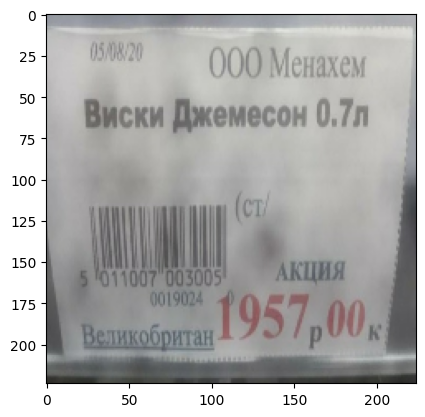

predicted = Сезон (122), label: Сезон (122)
(224, 224, 3)
1/1 [==============================] - 0s 34ms/step


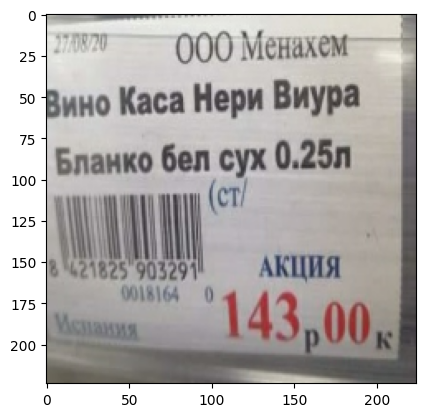

predicted = Сезон (122), label: Сезон (122)
(224, 224, 3)
1/1 [==============================] - 0s 32ms/step


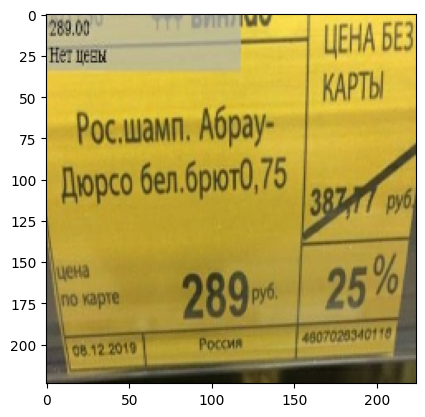

predicted = Винлаб (290), label: Винлаб (290)
(224, 224, 3)
1/1 [==============================] - 0s 37ms/step


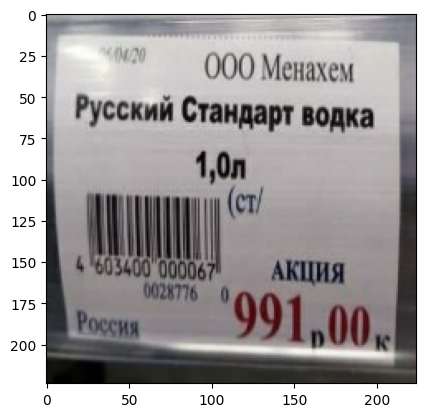

predicted = Сезон (122), label: Сезон (122)
(224, 224, 3)
1/1 [==============================] - 0s 35ms/step


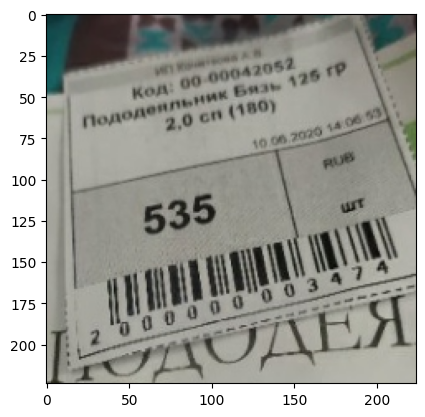

predicted = ДНС (310), label: 1000 мелочей (11)
(224, 224, 3)
1/1 [==============================] - 0s 35ms/step


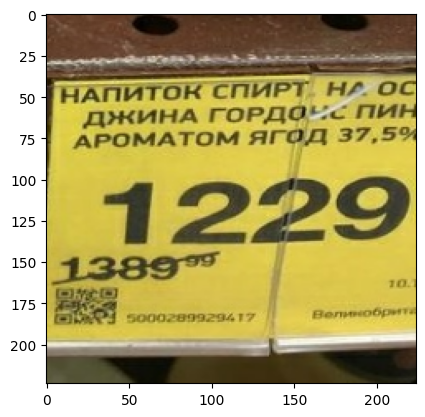

predicted = Красное и Белое (37), label: Красное и Белое (37)
(224, 224, 3)
1/1 [==============================] - 0s 31ms/step


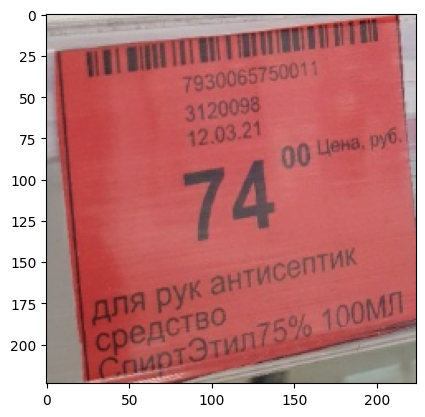

predicted = Улыбка Радуги (294), label: Улыбка Радуги (294)
(224, 224, 3)
1/1 [==============================] - 0s 34ms/step


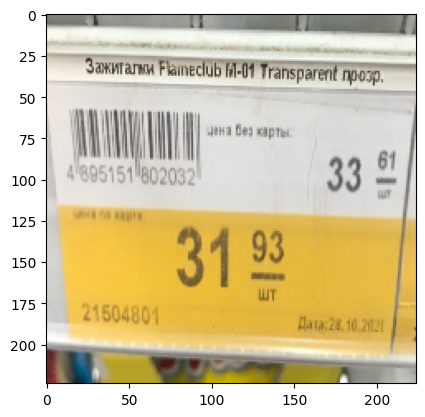

predicted = Стройпарк (182), label: Стройпарк (182)
(224, 224, 3)
1/1 [==============================] - 0s 36ms/step


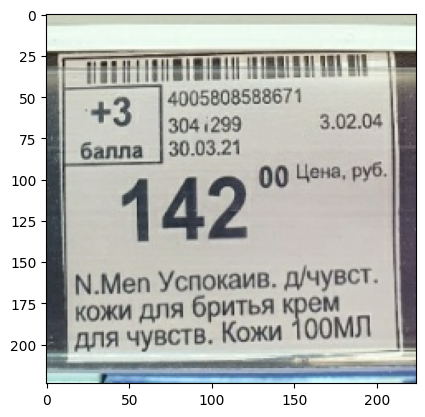

predicted = Улыбка Радуги (294), label: Улыбка Радуги (294)
(224, 224, 3)
1/1 [==============================] - 0s 35ms/step


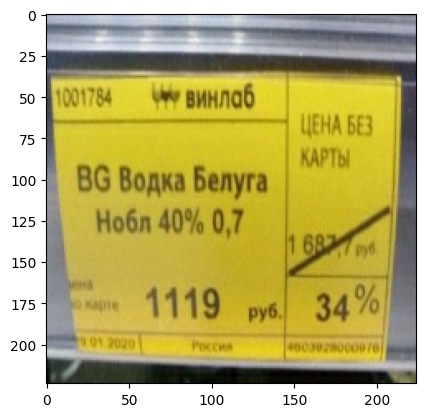

predicted = Винлаб (290), label: Винлаб (290)


In [113]:
# test dataset prediction visualization
test_ds = load_tfrecord_dataset(DATASET_TEST_PATH, batch_size=0)
samples = list(test_ds.take(10))

for item in samples:
    img = item[0]
    print(img.shape)
    lbl = item[1]
    # img = tf.cast(img, tf.uint8)
    # img = tf.cast(img, tf.uint8)
    predicted = model.predict(img[np.newaxis,...])[0]
    plt.figure()
    plt.imshow(img)
    plt.show()
    predicted = predicted.argmax()
    lbl = lbl.numpy().argmax()
    print(f'predicted = {CLASSES[predicted]} ({predicted}), label: {CLASSES[lbl]} ({lbl})')


/media/datasets/tag_segmentation/v4/source/img/cdc48a9621667e25d1ee67058a989175.jpg
1/1 [==============================] - 0s 40ms/step
174


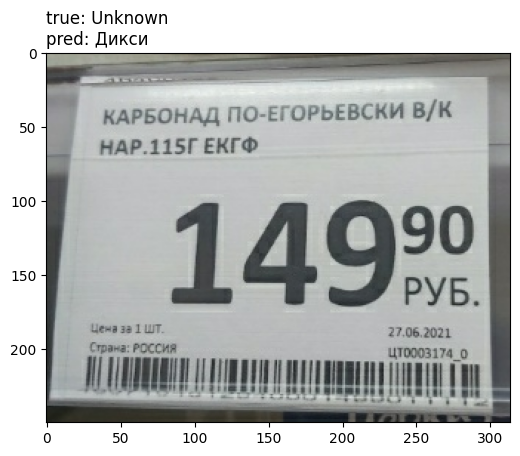

/media/datasets/tag_segmentation/v4/source/img/41f45421e2891d57b8547faccdbcedbb.jpg
1/1 [==============================] - 0s 35ms/step
198


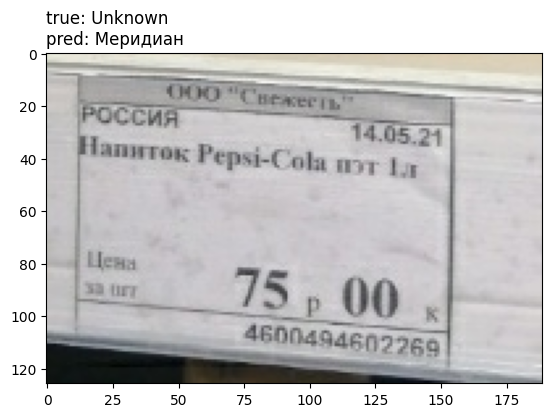

/media/datasets/tag_segmentation/v4/source/img/ffd9ba8004376eb85fec64f261b00106.jpg
1/1 [==============================] - 0s 36ms/step
274


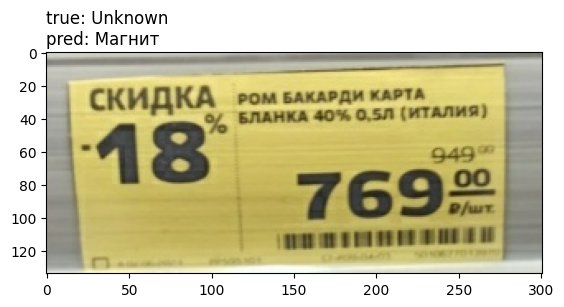

/media/datasets/tag_segmentation/v4/source/img/04badafd55357d00ffa0e46c745970ec.jpg
1/1 [==============================] - 0s 36ms/step
37


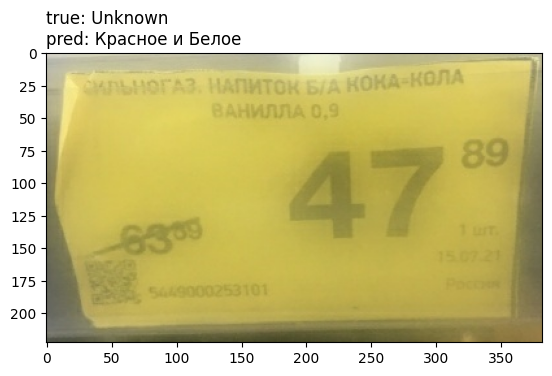

/media/datasets/tag_segmentation/v4/source/img/200e5fa545b590536352f106a943b24f.jpg
1/1 [==============================] - 0s 33ms/step
102


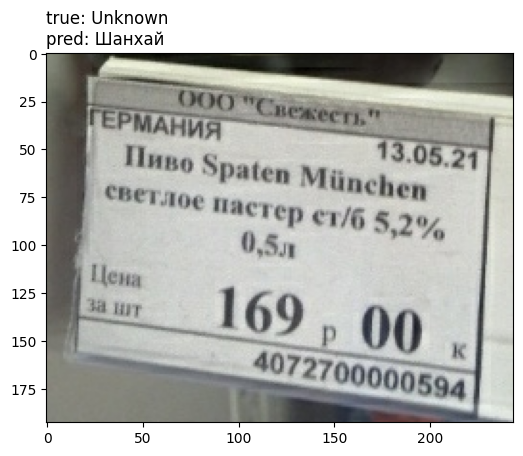

/media/datasets/tag_segmentation/v4/source/img/01ed8eef3e4a846787642a6d883eec48.jpg
1/1 [==============================] - 0s 35ms/step
174


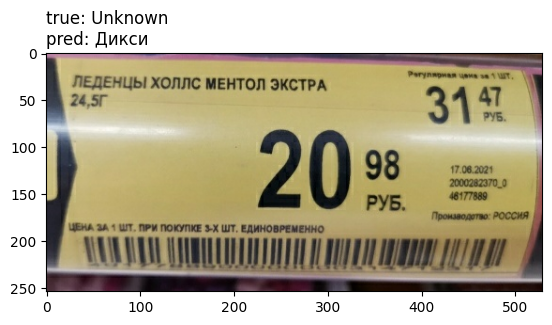

/media/datasets/tag_segmentation/v4/source/img/3b154676ad7658f350c9cf77801ed5c2.jpg
1/1 [==============================] - 0s 33ms/step
37


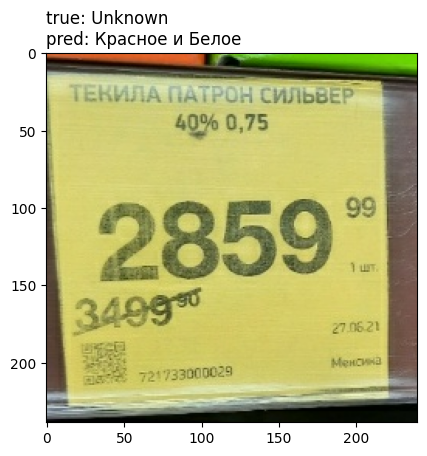

/media/datasets/tag_segmentation/v4/source/img/ac9a551e08bee1270bbe9ec88441176b.jpg
1/1 [==============================] - 0s 37ms/step
174


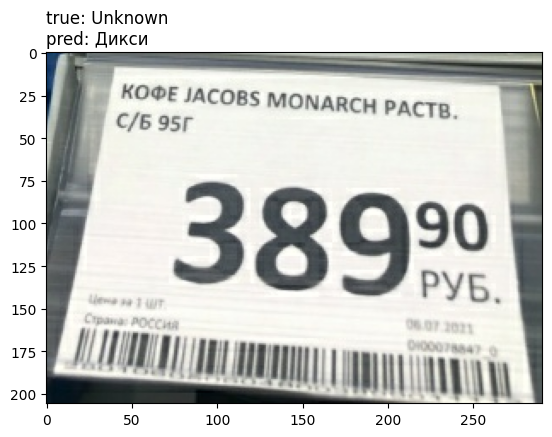

/media/datasets/tag_segmentation/v4/source/img/6774e924a14ac3d588925566917b404a.jpg
1/1 [==============================] - 0s 35ms/step
220


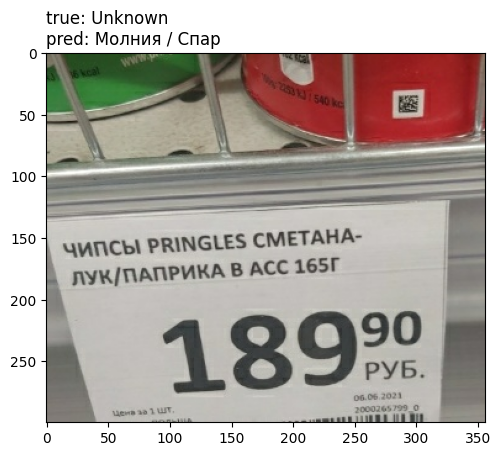

/media/datasets/tag_segmentation/v4/source/img/306c7982880bcdc253bccd6b612b055e.jpg
1/1 [==============================] - 0s 36ms/step
290


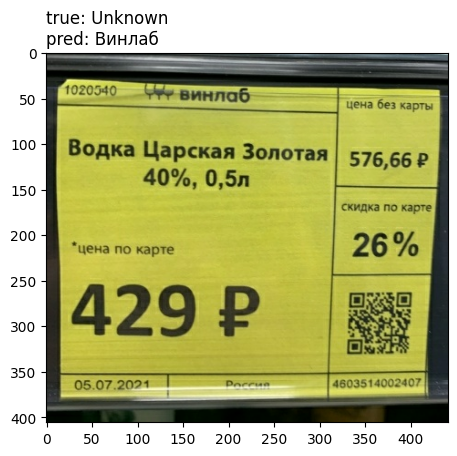

In [116]:

TEST_SAMPLES_DIR = '/media/datasets/tag_segmentation/v4/source/img'
# TEST_SAMPLES_DIR = SOURCE_IMG_PATH
sampes_flist = glob(f'{TEST_SAMPLES_DIR}/*.jpg')

for fpath in sampes_flist[-10:]:
    
    print(fpath)    
    try:
        img_class_id = int(fpath.split('.')[0].split('_')[-1])
    except Exception as ex:
        img_class_id = 0
    img_class_name = CLASSES[img_class_id]
    
    img = load_image(fpath)    
#     img_float = tf.cast(img, tf.float32)
    img_float = tf.image.resize(img, size=(IMG_HEIGHT, IMG_WIDTH))
    img_float = tf.math.divide(img_float, 127.5)
    img_float = tf.math.subtract(img_float, 1)
#     img = tf.cast(img, tf.float32)#.numpy()
    img_reshaped = img_float[tf.newaxis, ...]
    prediction = np.squeeze(model.predict(img_reshaped))
    prediction = prediction.argmax()
    print(prediction)

    predicted_class_name = CLASSES[prediction]
    plt.figure()
    plt.title(f'true: {img_class_name} \npred: {predicted_class_name}', loc='left')
    plt.imshow(img)
    plt.show()

# Confusion matrix

In [152]:
def evaluate_model(model, dataset):  
    ground_truth = []
    predictions  = []
    
    for sample in dataset:
        image, lbl = sample
        prediction = model(image).numpy()
        predictions.append(tf.argmax(prediction[0]).numpy())
        ground_truth.append(tf.argmax(lbl[0]).numpy())
        
    return ground_truth, predictions

In [162]:
test_dataset = load_tfrecord_dataset(DATASET_TEST_PATH, batch_size=128)
ground_truth, predictions = evaluate_model(model, test_dataset)

loading dataset: /media/datasets/tag_brands/classification/v2/target/tfrecord/test.tfrecord... Done!


In [179]:
def plot_confusion_matrix(predictions, labels):
    matrix = tf.math.confusion_matrix(labels, predictions).numpy()
    fig, ax = plt.subplots(figsize=(26, 24))
    hmap = sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='d', ax=ax)
    
#     cls_labels = list(set(labels) & set(CLASSES.keys()))
#     cls_labels = [CLASSES[cls] for cls in cls_labels]
    
#     hmap.set_yticklabels(cls_labels)
#     hmap.set_xticklabels(cls_labels, rotation=90)
    
    plt.title('Confusion Matrix for test dataset')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

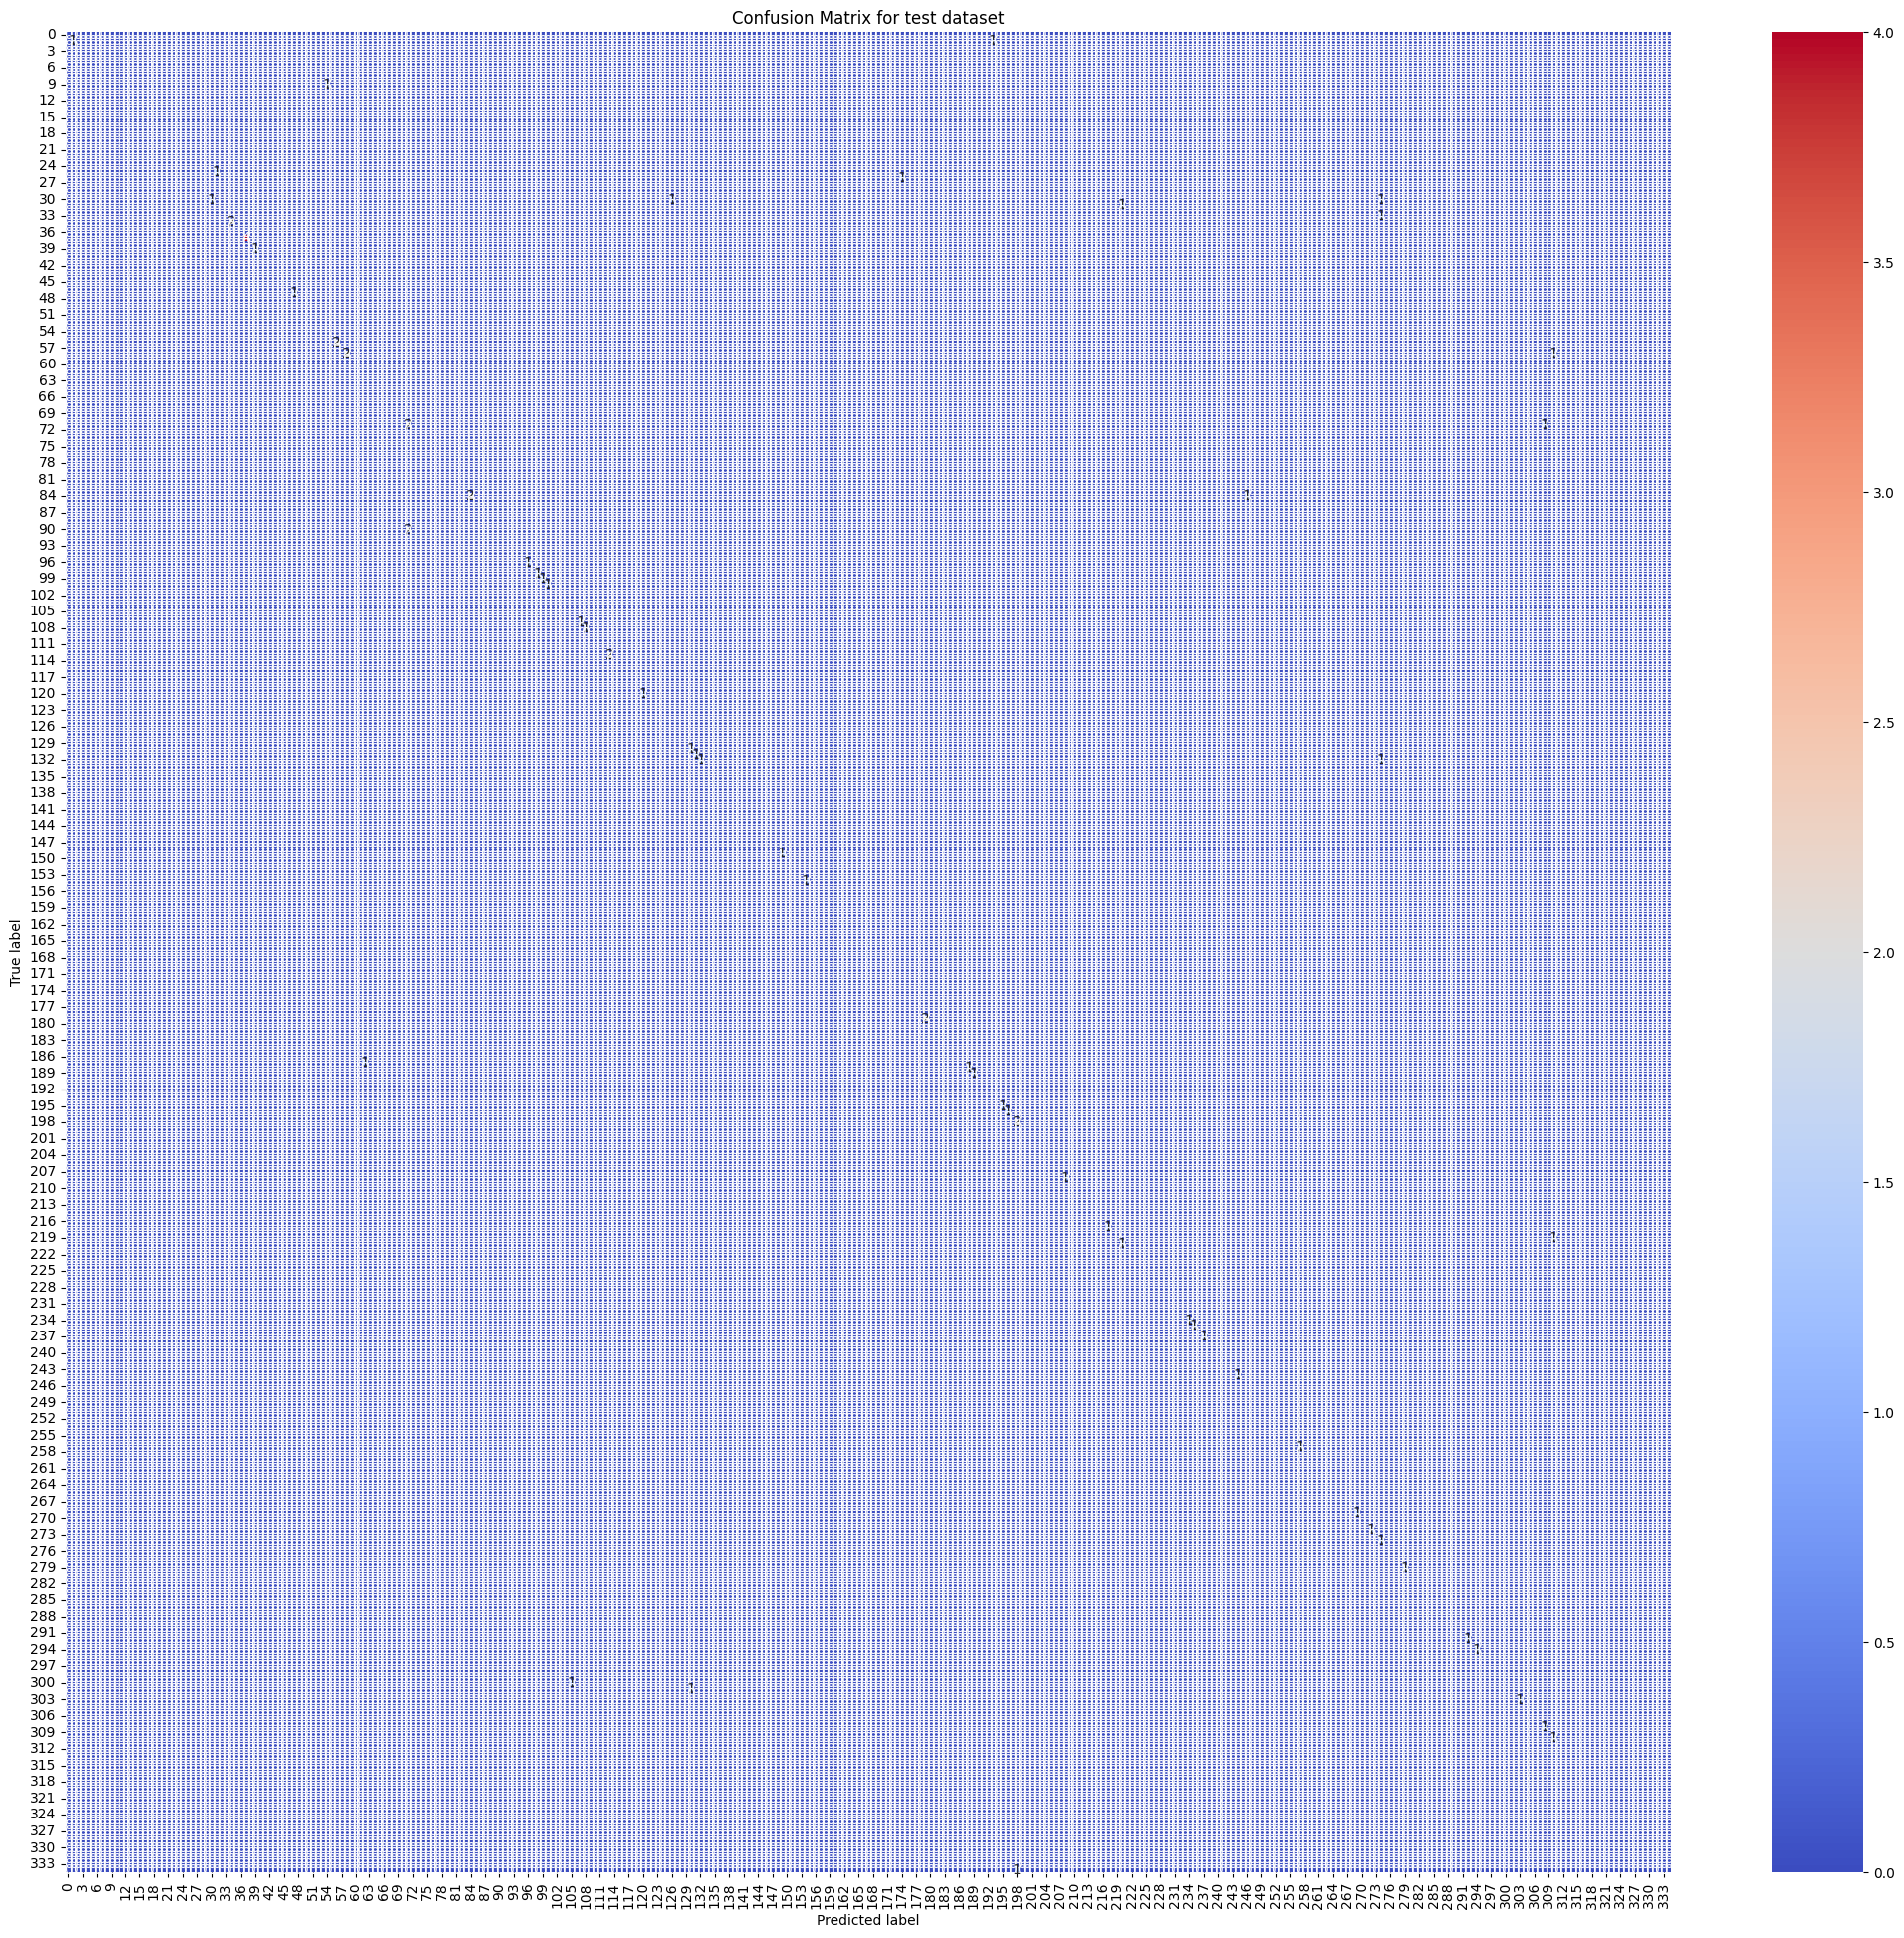

In [180]:
plot_confusion_matrix(predictions, ground_truth)